In [1]:
# define id (full id account) -> full WMS intance ID
INSTANCE_ID = '042dbf75-1db4-48af-aa2c-beee173d3339'  
# aldready inputted into config file. In case you put instance ID into cofniguration file you can leave this unchanged

In [2]:
# option settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import datetime
from base64 import b64encode
from ipyleaflet import Map, WMSLayer
from sentinelhub.data_request import WmsRequest, WcsRequest
from sentinelhub.constants import MimeType, CustomUrlParam
from sentinelhub.common import BBox, CRS
from time_lapse import SentinelHubTimelapse
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, CustomUrlParam, DataSource

In [4]:
### define functions

# function for plotting RGB images
def plot_image(data, factor=1):
    """
    Utility function for plotting RGB images. The numpy arrays returned by the WMS and WCS requests have channels
    ordered as Blue (`B02`), Green (`B03`), and Red (`B04`) therefore the order has to be reversed before ploting
    the image.
    """
    fig = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))
    rgb = data.astype(np.float32)
    if len(rgb.shape) == 3 and rgb.shape[2] == 3:
        rgb = rgb[..., [2, 1, 0]]
    plt.imshow(rgb * factor)

##### Function wrapper

If you want to repeat the previous steps systematically, a wrapper function can be created as below.

In [5]:
# define timelampse function
def make_timelapse(msg, bbox, time_interval, *, full_size=(int(1920 / 2), int(1080 / 2)), mask_images=[],
                   max_cc=0.01, scale_factor=0.2, fps=8, instance_id=INSTANCE_ID, layer, **kwargs):
    
    # call timelapse function
    timelapse = SentinelHubTimelapse(msg, bbox, time_interval, instance_id,
                                     full_size=full_size, layer=layer, **kwargs)
    timelapse.get_previews()
    timelapse.save_fullres_images()
    timelapse.plot_preview(filename='previews.pdf')
    timelapse.mask_cloudy_images(max_cloud_coverage=max_cc)
    timelapse.plot_cloud_masks(filename='cloudmasks.pdf')
    timelapse.plot_preview(filename='previews_with_cc.pdf')
    timelapse.mask_images(mask_images)
    timelapse.create_date_stamps()
    timelapse.create_timelapse(scale_factor=scale_factor)

    timelapse.make_gif(fps=fps)
    # timelapse.make_video(fps=fps)

### Get Coordinates

In [8]:
# specify centre of map
# view map
m = Map(center=[-1.410754, -78.193159], zoom=14)
m

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [14]:
# get bounds box
m.bounds

((-1.4450639061263335, -78.27741622924806),
 (-1.376420172259549, -78.10901641845705))

In [15]:
# define bounds box
map_bbox = BBox(bbox=([m.bounds[0][1], m.bounds[0][0],
                        m.bounds[1][1], m.bounds[1][0]]), crs=CRS.WGS84)

In [16]:
# specify wms and time?
sh_wms_url = 'https://services.sentinel-hub.com/ogc/wms/' + INSTANCE_ID + '?showlogo=0&time=2018-04-01/2018-05-18'

In [17]:
# define layer
m.add_layer(WMSLayer(url=sh_wms_url, layers="FALSE_COLOR", tile_size=512))

### Timelapse

What to add to csv:

- location id -> location_id var
- layer -> layer var
- timestamp -> .get_dates()
- label -> ('landslide', 'no_landslide')
- bbox (long1, lat1, long2, lat2)
- cloud covrage %

Data Collection Loop:
Assgin correct id for each instance.
Sent 2 -> timerange
1. for layer in layers + :
    for coords in coordinates:
        - create timeplapse
        - add metadata to csv
      
Sent 1 -> timerange
1. for coords in coordinates:
        - create timeplapse
        - add metadata to csv
        
DEM -> static 
1. for coords in coordinates:
        - create timeplapse
        - add metadata to csv

In [ ]:
# layers to use
'TRUE_COLOR'
'FALSE_COLOR'
'NDVI'
'MOISTURE_INDEX'
'SWIR'

In [22]:
# dir
save_path = 'timelapse_dir/model_data/'

# location id
loc_id = 'loc_id1'

# time interval
time_interval = ['2015-01-01', '2018-05-22']

# define layer
layer = 'FALSE_COLOR'

# folder name 
folder_name = (save_path + loc_id + '_' + layer)

# max cloud cover thres
cc_thres = 0.2

# size
tl_size = (int(1920/2), int(1080/2))

# mask index -> manually choose images
# mask_idxs = [7, 96, 112, 170, 186, 190]

INFO:time_lapse:Found 119 images of timelapse_dir/model_data/loc_id1_FALSE_COLOR between 2015-01-01 and 2018-05-22.
INFO:time_lapse:
I suggest you start by downloading previews first to see,
if BBOX is OK, images are usefull, etc...
Execute get_previews() method on your object.

INFO:time_lapse:119 previews have been downloaded and stored to numpy array of shape (119, 256, 455, 3).
INFO:time_lapse:Downloading cloud data and running cloud detection. This may take a while.


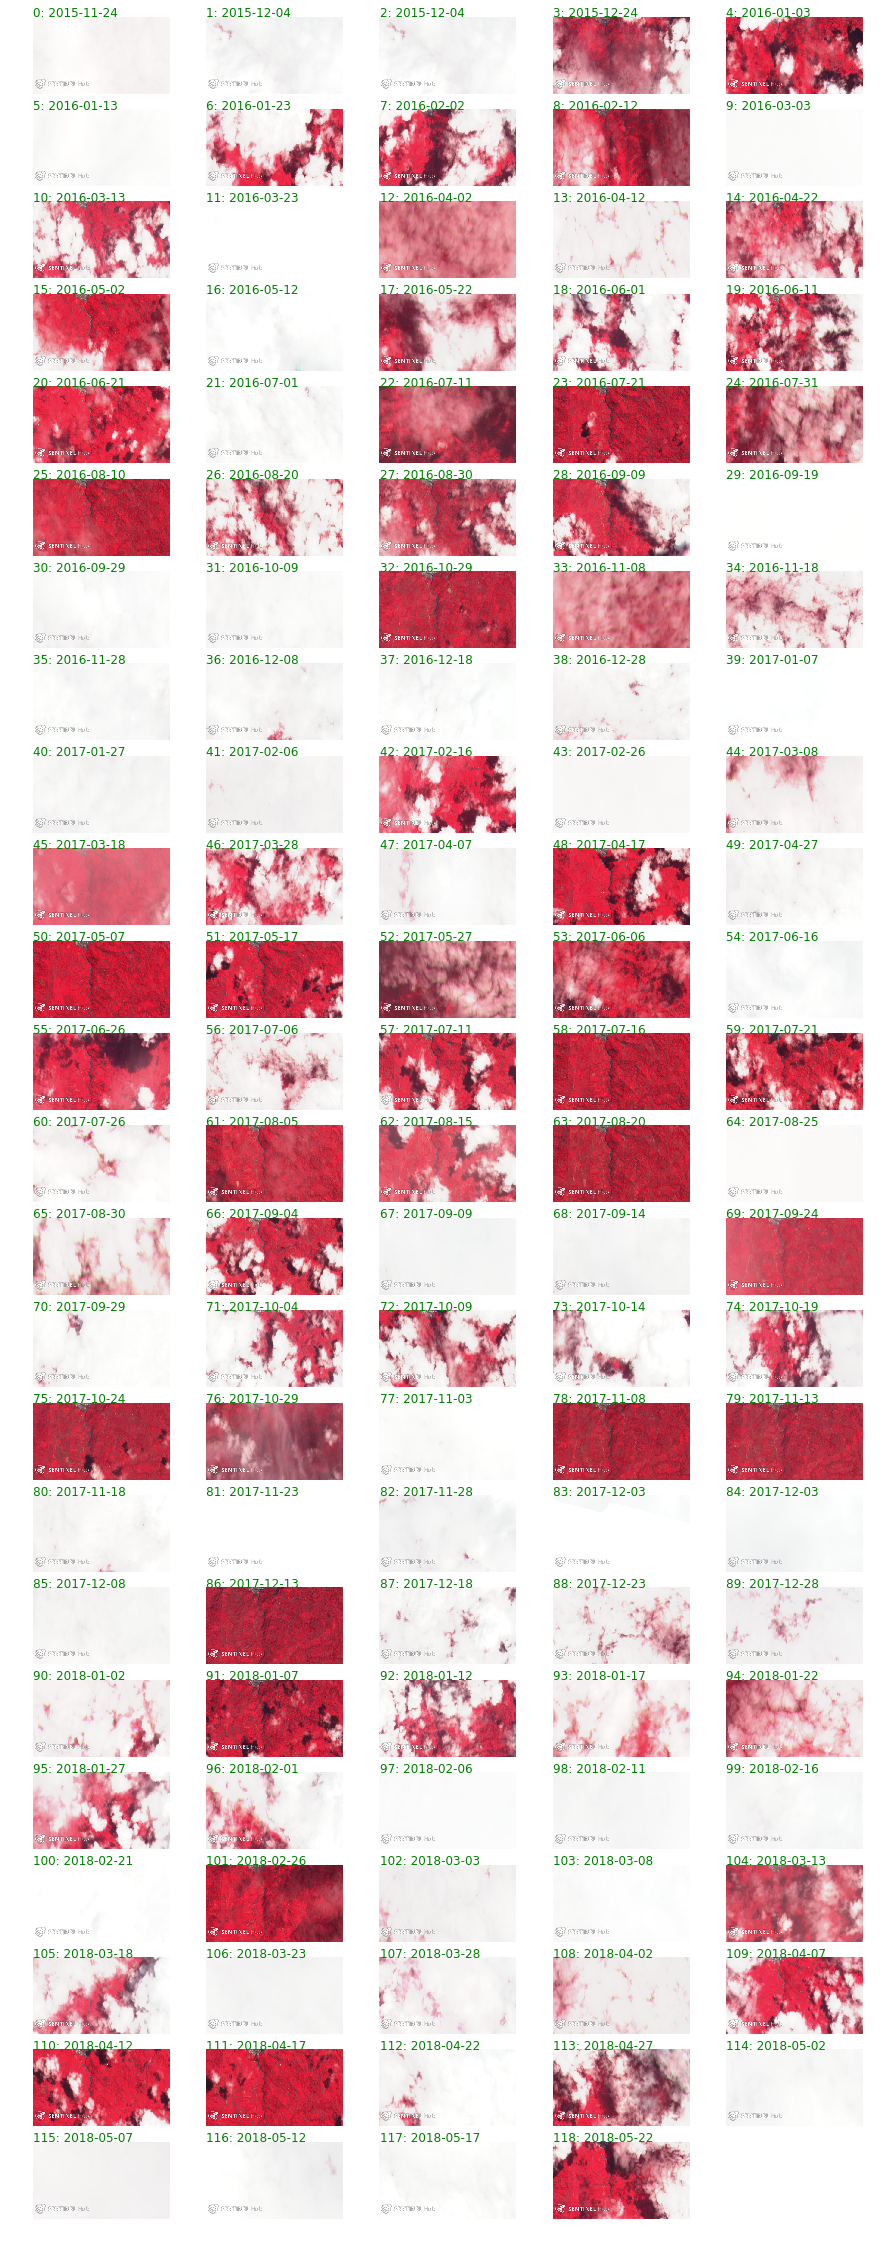

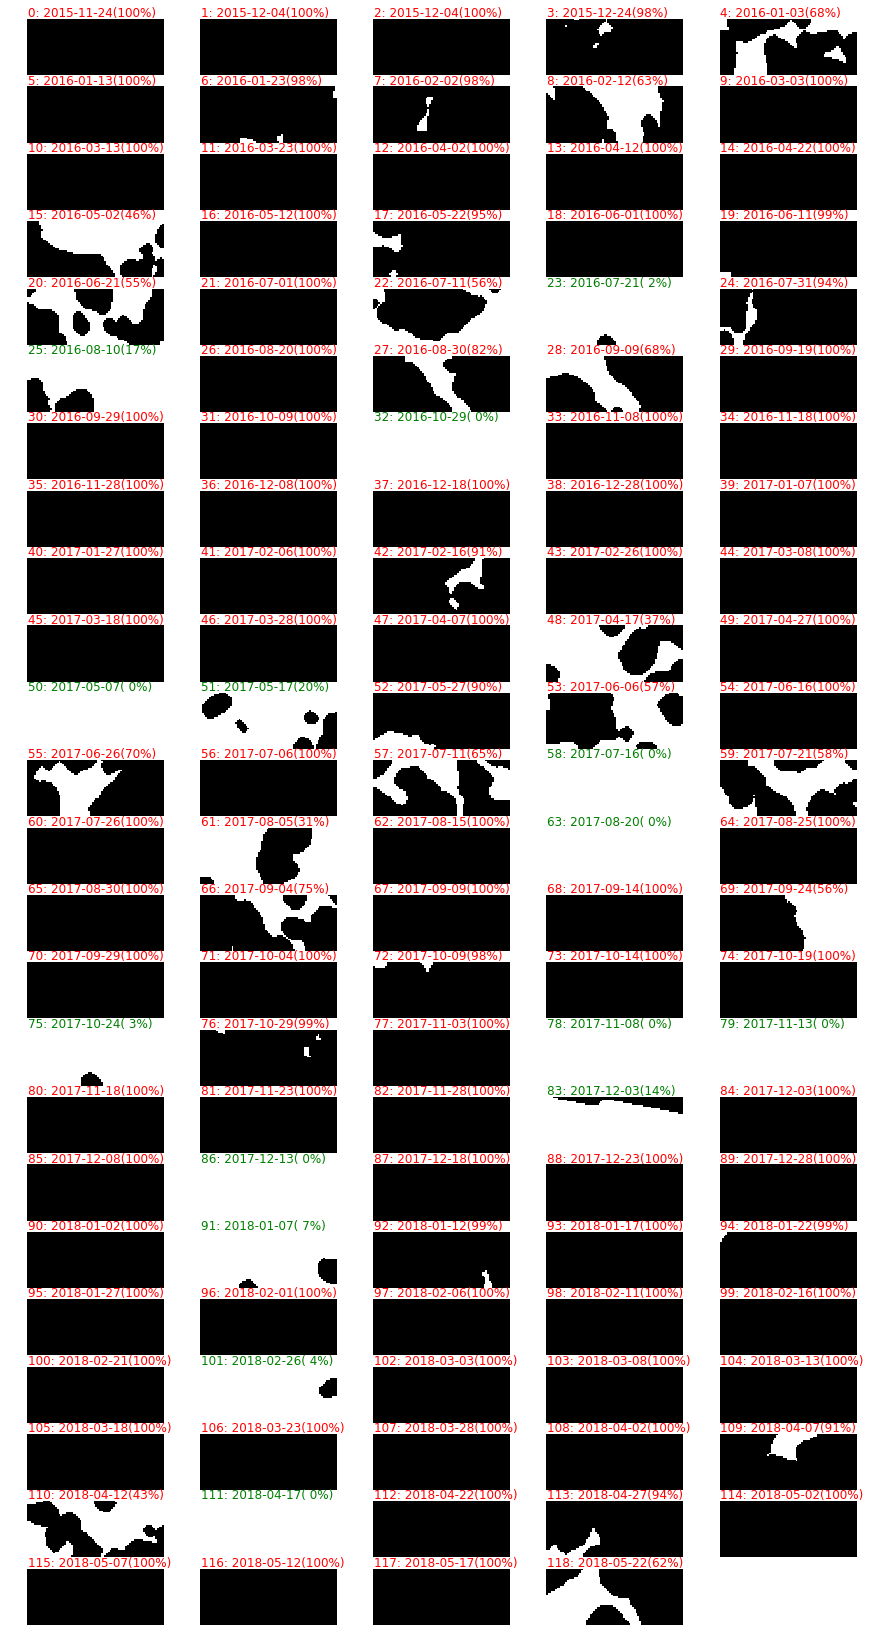

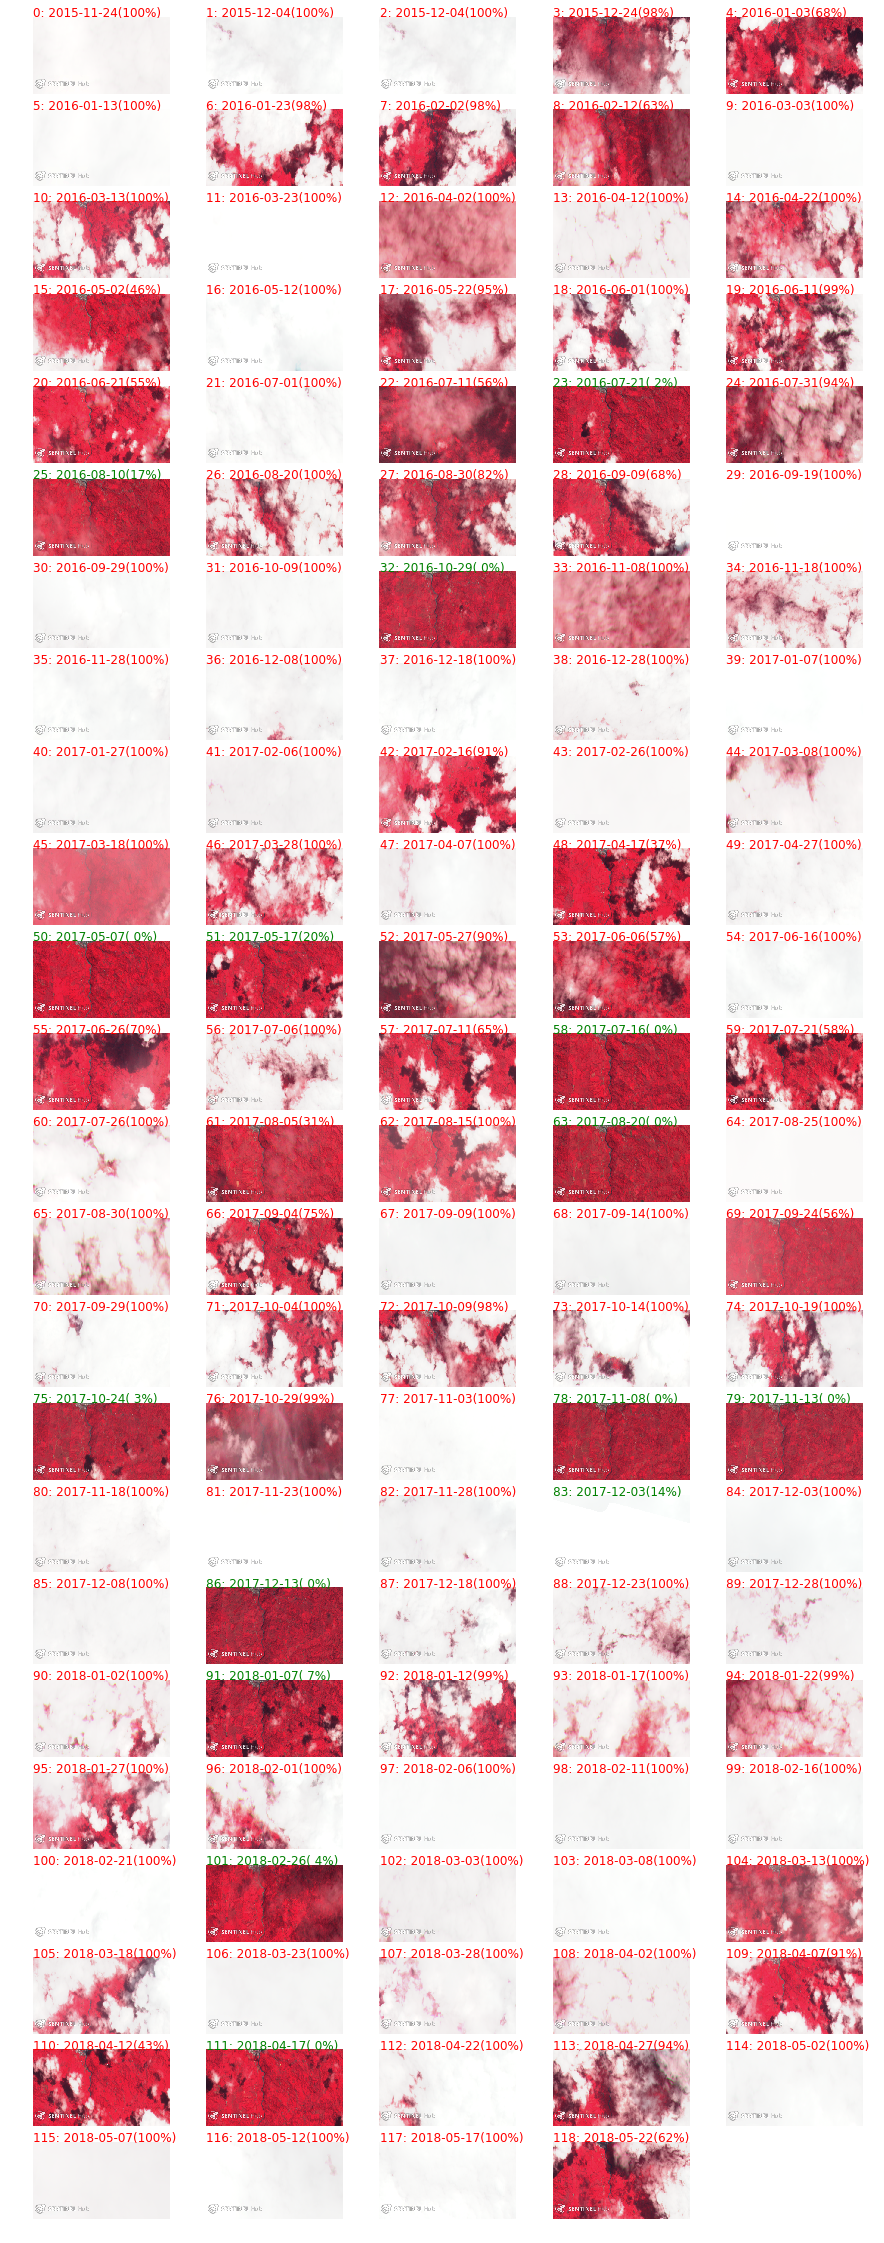

In [23]:
# execute timelapse 
make_timelapse(msg=folder_name,
               bbox=map_bbox,
               time_interval=time_interval,
               max_cc=cc_thres,
               layer=layer,
               scale_factor=0.2)

### DEM

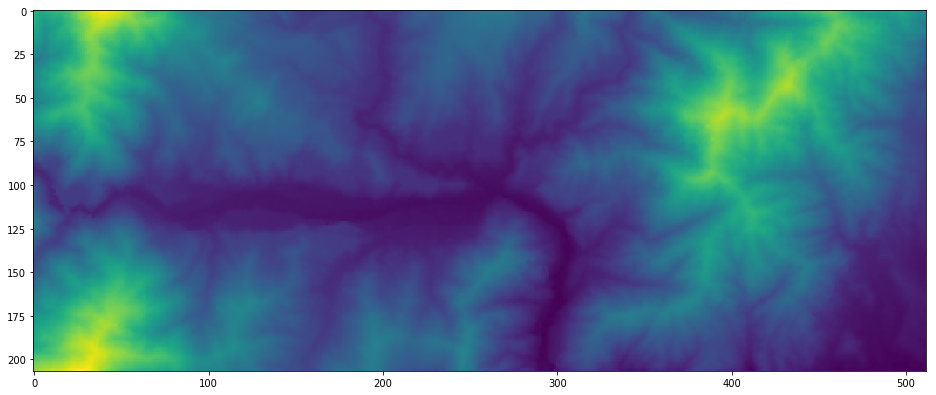

In [18]:
dem_request = WmsRequest(data_source=DataSource.DEM,
                         layer='TRUE-COLOR-DEM',
                         bbox=map_bbox,
                         width=512,
                         instance_id='99adef48-e72e-419b-995a-0ec60dd913d8', # DEM instance ID
                         image_format=MimeType.TIFF_d32f,
                         custom_url_params={CustomUrlParam.SHOWLOGO: False})

dem_image = dem_request.get_data()[0]
plot_image(dem_image,  1./255)

In [26]:
data_folder='/Users/Mille/GDriveMBD/IE/Term3/go-nuts-data4good/git-go-nuts-data4good/timelapse_dir/test'
dem_request_img = dem_request.save_data()

ValueError: Request parameter `data_folder` is not specified. In order to save data please set `data_folder` to location on your disk.

### Sentinel 1

s1_request = WmsRequest(data_source=DataSource.SENTINEL1_IW,
                        layer='TRUE-COLOR-S1-IW',
                        bbox=map_bbox,
                        time=time_interval,
                        width=512,
                        instance_id='13c30a60-b0b5-47b0-a9bf-b97cda6039f4',
                        custom_url_params={CustomUrlParam.SHOWLOGO: False}) # sentinel_1_IW instance ID

s1_data = s1_request.get_data()
plot_image(s1_data[-1],  1./255)

In [18]:
# enquire dates of images
print('These %d images were taken on the following dates:' % len(s1_data))
for index, date in enumerate(s1_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 75 images were taken on the following dates:
 - image 0 was taken on 2017-07-04 23:36:09
 - image 1 was taken on 2017-07-10 23:36:56
 - image 2 was taken on 2017-07-12 11:00:27
 - image 3 was taken on 2017-07-16 23:36:10
 - image 4 was taken on 2017-07-18 10:59:59
 - image 5 was taken on 2017-07-24 11:00:28
 - image 6 was taken on 2017-07-28 23:36:10
 - image 7 was taken on 2017-08-03 23:36:57
 - image 8 was taken on 2017-08-05 11:00:29
 - image 9 was taken on 2017-08-09 23:36:11
 - image 10 was taken on 2017-08-11 11:00:00
 - image 11 was taken on 2017-08-15 23:36:58
 - image 12 was taken on 2017-08-17 11:00:29
 - image 13 was taken on 2017-08-21 23:36:11
 - image 14 was taken on 2017-08-27 23:36:58
 - image 15 was taken on 2017-08-29 11:00:30
 - image 16 was taken on 2017-09-04 11:00:01
 - image 17 was taken on 2017-09-08 23:36:59
 - image 18 was taken on 2017-09-10 11:00:30
 - image 19 was taken on 2017-09-14 23:36:12
 - image 20 was taken on 2017-09-20 23:36:59
 - image 21 wa

### LandSat (more temporal data)

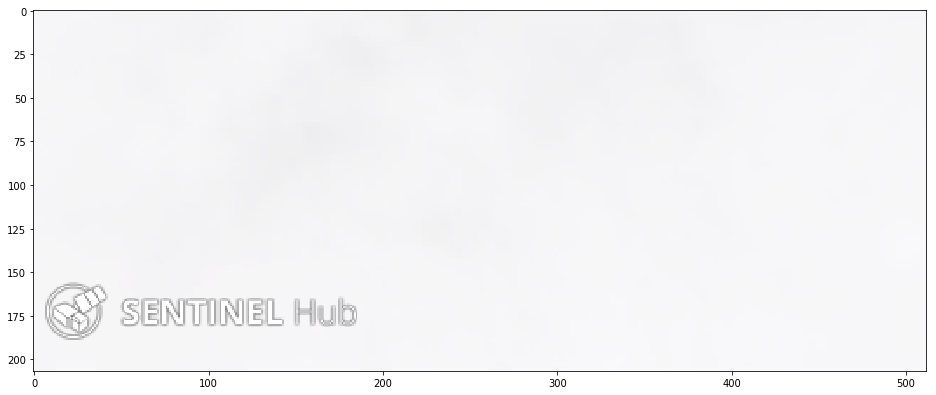

In [68]:
# landset8 time 
lat8_time_interval = ['2010-01-01', '2018-05-22']

l8_request = WmsRequest(data_source=DataSource.LANDSAT8,
                        layer='1_TRUE_COLOR',
                        bbox=map_bbox,
                        time=lat8_time_interval,
                        width=512,
                        instance_id='bc55e38c-67c2-4ffa-a08c-77936ab4035e')

l8_data = l8_request.get_data()
plot_image(l8_data[-1],  1./255)

In [18]:
# enquire dates of images
print('These %d images were taken on the following dates:' % len(l8_data))
for index, date in enumerate(l8_request.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

These 117 images were taken on the following dates:
 - image 0 was taken on 2013-04-18 15:28:06
 - image 1 was taken on 2013-05-04 15:28:06
 - image 2 was taken on 2013-05-20 15:28:19
 - image 3 was taken on 2013-06-05 15:28:20
 - image 4 was taken on 2013-06-21 15:28:12
 - image 5 was taken on 2013-07-07 15:28:17
 - image 6 was taken on 2013-07-23 15:28:16
 - image 7 was taken on 2013-08-08 15:28:18
 - image 8 was taken on 2013-08-24 15:28:20
 - image 9 was taken on 2013-09-09 15:28:19
 - image 10 was taken on 2013-09-25 15:28:10
 - image 11 was taken on 2013-10-11 15:28:11
 - image 12 was taken on 2013-10-27 15:28:01
 - image 13 was taken on 2013-11-12 15:28:01
 - image 14 was taken on 2013-11-28 15:27:55
 - image 15 was taken on 2013-12-14 15:27:51
 - image 16 was taken on 2013-12-30 15:27:42
 - image 17 was taken on 2014-01-15 15:27:26
 - image 18 was taken on 2014-01-31 15:27:22
 - image 19 was taken on 2014-02-16 15:27:08
 - image 20 was taken on 2014-03-04 15:26:52
 - image 21 w